In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
from numba import njit

import bayesflow as bf
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

import sys
sys.path.append("../assets/")
from priors import sample_gamma, sample_eta, sample_random_walk
from likelihood import sample_non_stationary_diffusion_process, _sample_diffusion_trial
from context import generate_context
from configurations import approximator_settings    

## Model

$$
\begin{align}
x &\sim wiener(v_t, a_t, \tau_t, \beta) \\
v_t &= v_0 + b_{v, t} * \text{validity} \\
b_{v, t} &= \mathcal{T}(b_{v, 0:t-1}, \eta_v, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, \eta_v) \\
a_t &= \mathcal{T}(a_{0:t-1}, \eta_a, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, \eta_a) \\
\tau_t &= \tau_{0, t} + b_{\tau} * \text{face context} \\
\tau_{0, t} &= \mathcal{T}(\tau_{0, 0:t-1}, \eta_{\tau}, \xi_t) \quad\, \text{with}\quad \xi_t \sim p(\xi \,|\, {\tau}) \\

\end{align}
$$


### Parameter overview

**Global parameters $\eta$ (Static transition model parameters)**

$\eta = \{\eta_v, \eta_a, \eta_{\tau}\}$

**Local parameters $\theta_{1:T}$ (Time-varying DDM parameters)**

$\theta_{1:T} = \{b_{v, 1:T},  a_{1:T}, \tau_{1:T}\}$

**Shared parameters $\gamma$ (Static DDM parameters)**

$\gamma = \{v_0,  b_{\tau}, \beta\}$

## Constants

In [17]:
%%time
for i in range(10000):
    _sample_diffusion_trial(1, 1, 0.5, 0.5)

CPU times: user 197 ms, sys: 2.01 ms, total: 199 ms
Wall time: 199 ms


In [18]:
TRAIN_NETWORK = True
FIT_MODEL = True

In [55]:
NUM_OBS = 246
RT_UPPER_BOUND = 6.0
RT_LOWER_BOUND = 0.2
NUM_SAMPLES = 2000
NUM_RESIMULATIONS = 500

LOCAL_PARAM_LABELS = [
    'Sensitivity', 'Threshold', 'Non-decision time',
]
LOCAL_PARAM_NAMES  = [
    r'b_v', r'a', r'\tau_0'
]

GLOBAL_PARAM_LABELS = [
    'Baseline drift', 'Effect on NDT', 'Bias',
]
GLOBAL_PARAM_NAMES  = [
    r'$v_0$', r'$b_{\tau}$', r'$\beta$'
]

FONT_SIZE_1 = 24
FONT_SIZE_2 = 22
FONT_SIZE_3 = 18

In [43]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Exemplar parameter trajectory

In [20]:
eta = sample_eta()
theta_t = sample_random_walk(eta)

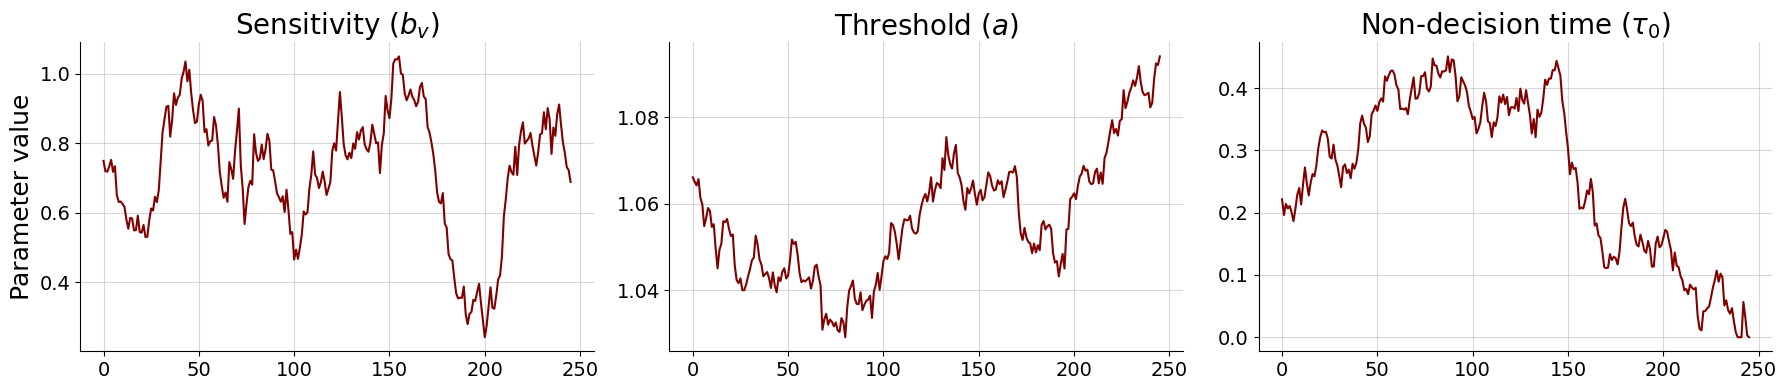

In [21]:
time = np.arange(theta_t.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_t[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    if i > 3:
        ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

In [22]:
prior = bf.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
    shared_prior_fun=sample_gamma
    )

context = bf.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
    )

likelihood = bf.simulation.Simulator(
    simulator_fun=sample_non_stationary_diffusion_process,
    context_generator=context,
    )

model = bf.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="random_walk_diffusion_model",
)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 246, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 246, 2)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 246, 3)
INFO:root:Shape of shared_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


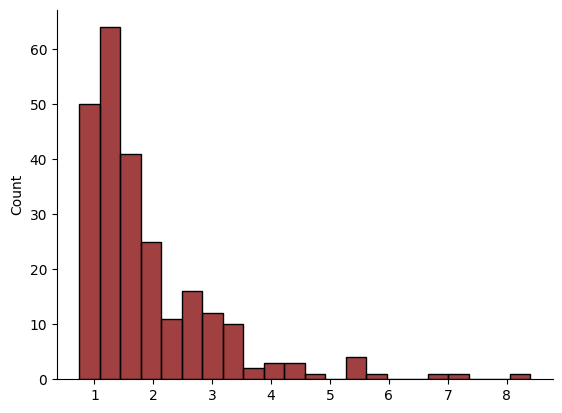

In [23]:
sim_data = model(1)
sns.histplot(sim_data['sim_data'][0, :, 0], color='maroon')
sns.despine()

## Configurator

In [24]:
# N = 50000
# prior_samples = prior(N)

In [25]:
# HYPER_PRIOR_MEAN = np.round(prior_samples['hyper_parameters'].mean(axis=0), 2)
# HYPER_PRIOR_STD = np.round(prior_samples['hyper_parameters'].std(axis=0), 2)

# local_samples = prior_samples['local_parameters'].reshape(-1, prior_samples['local_parameters'].shape[-1])
# LOCAL_PRIOR_MEAN = np.round(local_samples.mean(axis=0), 2)
# LOCAL_PRIOR_STD = np.round(local_samples.std(axis=0), 2)

In [26]:
def configure_input(raw_dict):
    # prepare data
    data = raw_dict.get("sim_data")
    truth_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 0][:, :, None]
    face_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 1][:, :, None]
    validity_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 2][:, :, None]
    summary_conditions = np.c_[data, truth_context, to_categorical(face_context), validity_context]

    theta_t = raw_dict.get("local_prior_draws")
    eta = raw_dict.get("hyper_prior_draws")
    gamma = raw_dict.get("shared_prior_draws")

    # out_dict = dict(
    #     local_parameters=((theta_t - LOCAL_PRIOR_MEAN) / LOCAL_PRIOR_STD).astype(np.float32),
    #     hyper_parameters=((eta - HYPER_PRIOR_MEAN) / HYPER_PRIOR_STD).astype(np.float32),
    #     summary_conditions=summary_conditions.astype(np.float32),
    # )
    out_dict = dict(
        local_parameters=theta_t.astype(np.float32),
        hyper_parameters=eta.astype(np.float32),
        shared_parameters=gamma.astype(np.float32),
        summary_conditions=summary_conditions.astype(np.float32),
    )
    return out_dict

# Neural Approximator

In [27]:
summary_network = bf.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [28]:
local_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=3,
        **approximator_settings.get("local_amortizer_settings")
    )
)

global_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=3+3,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [29]:
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/model_3"
)

INFO:root:Loaded loss history from ../checkpoints/model_3/history_100.pkl.
INFO:root:Networks loaded from ../checkpoints/model_3/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

In [ ]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=100,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())

# Validation

# Application

## Fit to Empirical Data

In [30]:
data = pd.read_excel('../data_super.xlsx')
data_witness = data.loc[(data.condition == "Kongruenz Witness") | (data.condition == "Inkongruenz Witness")]
subject_id = data_witness.subject_id.unique()

In [31]:
person_data = data_witness.loc[data_witness.subject_id == 1]
person_data.loc[:, "correctResponse"] = np.where(person_data["correctResponse"] == "Lüge", 0, 1)

truth_context = person_data.correctResponse
face_context = person_data.Anzahl_Gesichter - 1
validity_context = person_data.ValiditätenInv - 0.5

resp = person_data.Antwort
rt = person_data.duration / 1000
rt.loc[rt > RT_UPPER_BOUND] = np.nan
rt.loc[rt < RT_LOWER_BOUND] = np.nan
mask = np.isfinite(rt)

data_configured = np.c_[
    rt[mask], resp[mask], truth_context[mask],
    to_categorical(face_context[mask]), validity_context[mask]
][None, :, :].astype(np.float32)

post_samples = amortizer.sample({'summary_conditions': data_configured}, n_samples=NUM_SAMPLES)

In [32]:
if FIT_MODEL:
    local_post_samples = np.full((len(subject_id), NUM_OBS, NUM_SAMPLES, 3), np.nan)
    global_post_samples = np.full((len(subject_id), NUM_SAMPLES, 6), np.nan)

    resim_data = np.full((len(subject_id), NUM_RESIMULATIONS, NUM_OBS, 7), np.nan)

    for i, id in enumerate(tqdm(subject_id)):
        # model fitting
        person_data = data_witness.loc[data_witness.subject_id == id]
        person_data.loc[:, "correctResponse"] = np.where(person_data["correctResponse"] == "Lüge", 0, 1)

        truth_context = person_data.correctResponse
        face_context = person_data.Anzahl_Gesichter - 1
        validity_context = person_data.ValiditätenInv - 0.5

        resp = person_data.Antwort
        rt = person_data.duration / 1000
        rt.loc[rt > RT_UPPER_BOUND] = np.nan
        rt.loc[rt < RT_LOWER_BOUND] = np.nan
        mask = np.isfinite(rt)

        data_configured = np.c_[
            rt[mask], resp[mask], truth_context[mask],
            to_categorical(face_context[mask]), validity_context[mask]
        ][None, :, :].astype(np.float32)

        post_samples = amortizer.sample({'summary_conditions': data_configured}, n_samples=NUM_SAMPLES)
        local_post_samples[i, mask] = post_samples['local_samples']
        global_post_samples[i] = post_samples['global_samples']

        # posterior resimulation
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        local_samples = post_samples['local_samples'][:, idx].astype(np.float32)
        global_samples = post_samples['global_samples'][idx, -3:].astype(np.float32)
        context = np.c_[truth_context[mask], face_context[mask], validity_context[mask]].astype(np.float32)
        sub_id = np.full((NUM_RESIMULATIONS, NUM_OBS), id)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS))
        for j in range(NUM_RESIMULATIONS):
            x = sample_non_stationary_diffusion_process([local_samples[:, j], global_samples[j]], context)
            resim_data[i, j, mask, 2:] = np.c_[x, context]
        resim_data[i, :, :, 0] = sub_id
        resim_data[i, :, :, 1] = sim_seq

    np.save("../data/local_post_samples.npy", local_post_samples)
    np.save("../data/global_post_samples.npy", global_post_samples)
    np.save("../data/post_resim_data.npy", resim_data)
else:
    local_post_samples = np.load("../data/local_post_samples.npy")
    global_post_samples = np.load("../data/global_post_samples.npy")
    post_resim_data = np.load("../data/post_resim_data.npy")

100%|██████████| 79/79 [17:38<00:00, 13.40s/it]


## Parameter Trajectory

In [33]:
local_post_median_congruent = np.nanmedian(local_post_samples[:42], axis=2)
local_post_mean_congruent = np.nanmean(local_post_median_congruent, axis=0)
local_post_ci_congruent = np.nanquantile(local_post_median_congruent, [0.05, 0.95], axis=0)

local_post_median_incongruent = np.nanmedian(local_post_samples[42:], axis=2)
local_post_mean_incongruent = np.nanmean(local_post_median_incongruent, axis=0)
local_post_ci_incongruent = np.nanquantile(local_post_median_incongruent, [0.05, 0.95], axis=0)

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


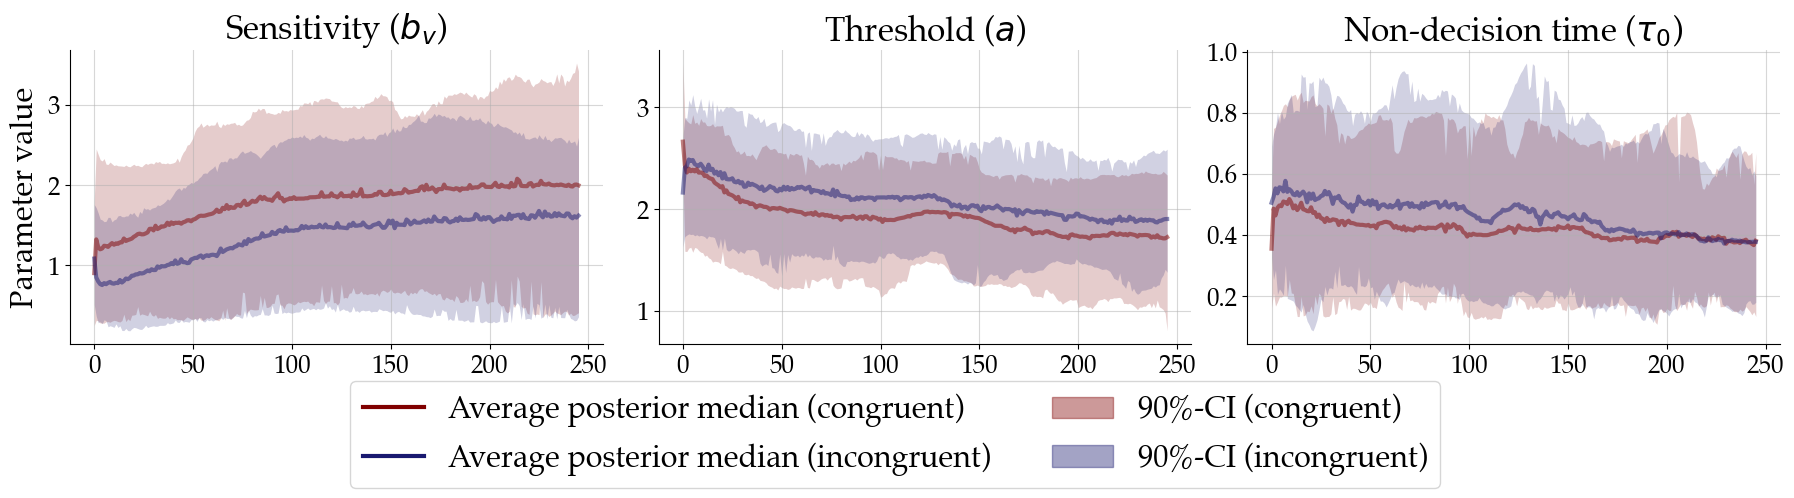

In [50]:
time = np.arange(local_post_mean_congruent.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(18, 4))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        local_post_mean_congruent[:, i],
        color='maroon', alpha=0.5, linewidth=3
    )
    ax.fill_between(
        time,
        local_post_ci_congruent[0, :, i],
        local_post_ci_congruent[1, :, i],
        color='maroon', alpha=0.2, linewidth=0
    )
    ax.plot(
        time,
        local_post_mean_incongruent[:, i],
        color='midnightblue', alpha=0.5, linewidth=3
    )
    ax.fill_between(
        time,
        local_post_ci_incongruent[0, :, i],
        local_post_ci_incongruent[1, :, i],
        color='midnightblue', alpha=0.2, linewidth=0
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    if i > 3:
        ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

handles = [
    Line2D(
        xdata=[], ydata=[], markersize=10, lw=3,
        color='maroon', label='Average posterior median (congruent)'
    ),
    Line2D(
        xdata=[], ydata=[], markersize=10, lw=3,
        color='midnightblue', label='Average posterior median (incongruent)'
    ),
    Patch(
        color='maroon', label='Average posterior median (congruent)', alpha=0.4
    ),
    Patch(
        color='midnightblue', label='Average posterior median (incongruent)', alpha=0.4
    )
]

fig.subplots_adjust(hspace=0.5)
fig.legend(
    handles,
    ['Average posterior median (congruent)', 'Average posterior median (incongruent)',
    '90%-CI (congruent)', '90%-CI (incongruent)'],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.1),
    loc="center", ncol=2
)

sns.despine()
fig.tight_layout()
fig.savefig("../plots/average_param_trajectory.pdf", dpi=300, bbox_inches="tight")

## Shared Parameters

In [52]:
shared_post_samples = global_post_samples[:, :, -3:]

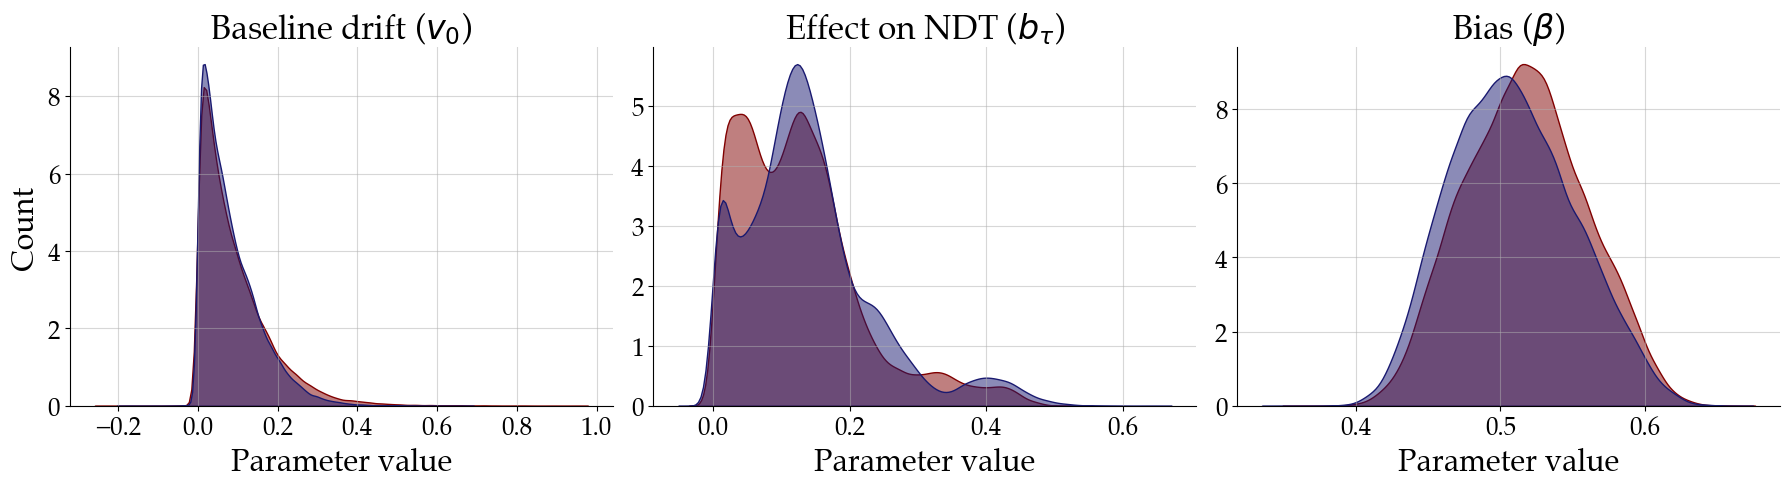

In [66]:
fig, axarr = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axarr.flat):
    sns.kdeplot(
        shared_post_samples[:42, :, i].flatten(),
        fill='maroon', alpha=0.5, ax=ax, color='maroon'
    )
    sns.kdeplot(
        shared_post_samples[42:, :, i].flatten(),
        fill='midnightblue', alpha=0.5, ax=ax, color='midnightblue'
    )
    ax.grid(alpha=0.5)
    ax.set_title(f'{GLOBAL_PARAM_LABELS[i]} ({GLOBAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Count", fontsize=FONT_SIZE_2)
    else:
        ax.set_ylabel("", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Parameter value", fontsize=FONT_SIZE_2)
sns.despine()
fig.tight_layout()
fig.savefig("../plots/average_global_parameter.pdf", dpi=300, bbox_inches="tight")

## Posterior Re-simulation

In [35]:
emp_df = data_witness.loc[:, ("condition", "subject_id", "Antwort", "correct", "correctResponse", "Anzahl_Gesichter", "ValiditätenInv", "duration")]
emp_df = emp_df.rename(
    columns={
        "subject_id": "id", "Antwort": "resp", "correctResponse": "truth_context",
        "Anzahl_Gesichter": "face_context", "ValiditätenInv": "validity_context", "duration": "rt"})

emp_df.loc[:, "rt"] = emp_df.rt / 1000
emp_df.loc[emp_df["rt"] > 6.0, "rt"] = np.nan
emp_df.loc[emp_df["rt"] < 0.2, "rt"] = np.nan
emp_df['correct'] = emp_df['correct'].astype(str)
emp_df.loc[:, "correct"] = np.where(emp_df["correct"] == "True", 1, 0)

emp_df.loc[:, "condition"] = np.where(emp_df["condition"] == "Kongruenz Witness", 1, 0)
emp_df.loc[:, "truth_context"] = np.where(emp_df["truth_context"] == "Lüge", 0, 1)
emp_df.loc[:, "face_context"] = emp_df.face_context - 1
emp_df.loc[:, "validity_context"] = emp_df.validity_context - 0.5

In [36]:
reshaped_data = resim_data.reshape(-1, 7)
resim_df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'resp', 'truth_context', 'face_context', 'validity_context'])
resim_df["condition"] = np.where(resim_df["id"] < 43, 1, 0)
resim_df["correct"] = np.where(resim_df["resp"] == resim_df["truth_context"], 1, 0)

In [37]:
# grouped_data = resim_df.groupby(['condition', 'validity_context'])
# resim_summaries = grouped_data.agg({
#             'rt': ['median', "std"],
#             'correct': ['mean', "std"]
#         }).reset_index(drop=False)
# resim_summaries.columns = ["condition", "validity_context", 'rt_median', 'rt_std', 'acc', 'acc_std']

grouped_data = resim_df.groupby(['id', 'condition', 'validity_context'])
resim_summaries = grouped_data.agg({
            'rt': ['median'],
            'correct': ['mean']
        }).reset_index(drop=False)
resim_summaries.columns = ['id', "condition", "validity_context", 'rt_median', 'acc']

grouped_data = resim_summaries.groupby(['condition', 'validity_context'])
resim_summaries = grouped_data.agg({
            'rt_median': ['mean', 'std'],
            'acc': ['mean', 'std']
        }).reset_index(drop=False)
resim_summaries.columns = ["condition", "validity_context", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']

In [38]:
# grouped_data = emp_df.groupby(['condition', 'validity_context'])
# empiric_summaries = grouped_data.agg({
#             'rt': ['median', "std"],
#             'correct': ['mean', "std"]
#         }).reset_index(drop=False)
# empiric_summaries.columns = ["condition", "validity_context", 'rt_median', 'rt_std', 'acc', 'acc_std']
# empiric_summaries

grouped_data = emp_df.groupby(['id', 'condition', 'validity_context'])
empiric_summaries = grouped_data.agg({
            'rt': ['median'],
            'correct': ['mean']
        }).reset_index(drop=False)
empiric_summaries.columns = ['id', "condition", "validity_context", 'rt_median', 'acc']

grouped_data = empiric_summaries.groupby(['condition', 'validity_context'])
empiric_summaries = grouped_data.agg({
            'rt_median': ['mean', 'std'],
            'acc': ['mean', 'std']
        }).reset_index(drop=False)
empiric_summaries.columns = ["condition", "validity_context", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']

In [39]:
summaries = [empiric_summaries, resim_summaries]

ESCAPE = [-0.2, 0.2]
X_AXIS_VALUES = np.arange(8) * 1.5
COLOR = ['black', 'maroon']
CONDITION_NAMES = ['Incongruent', 'Congruent']
LABELS = ["Empiric", "Re-simulated"]

## Response Times

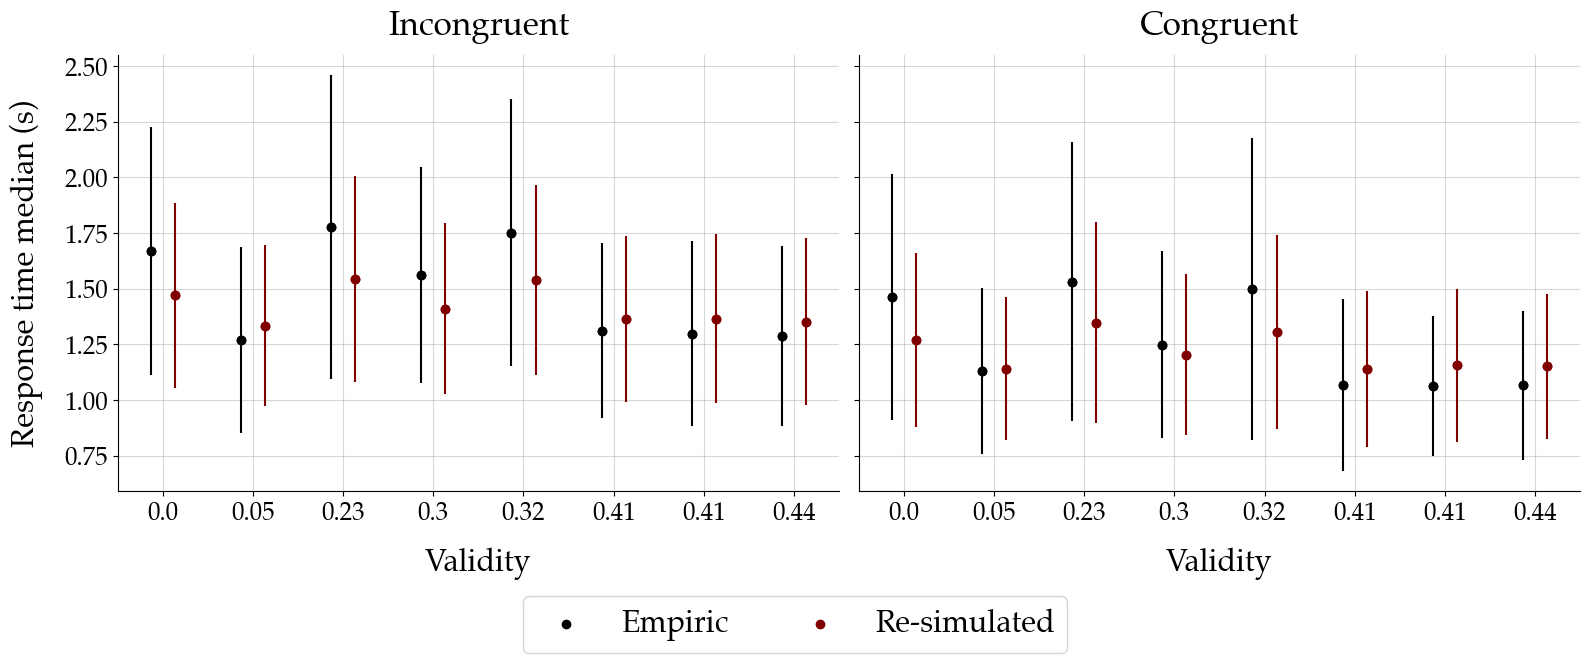

In [67]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, ax in enumerate(axarr.flat):
    for j in range(2):
        ax.scatter(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_rt_median'],
            color=COLOR[j], label=LABELS[j]
        )
        ax.errorbar(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_rt_median'],
            yerr= summaries[j].loc[summaries[j].condition == i, 'std_rt_median'],
            fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
        )
    ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity_context'].unique().round(decimals=2))
    ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Response time median (s)", labelpad=15, fontsize=FONT_SIZE_2)
        fig.legend(
            fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
            loc="center", ncol=5
        )
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_title(CONDITION_NAMES[i], pad=15, fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.5)
fig.subplots_adjust(hspace=0.5)

fig.tight_layout()
sns.despine()
fig.savefig("../plots/post_resim_rt.pdf", dpi=300, bbox_inches="tight")

## Accuracy

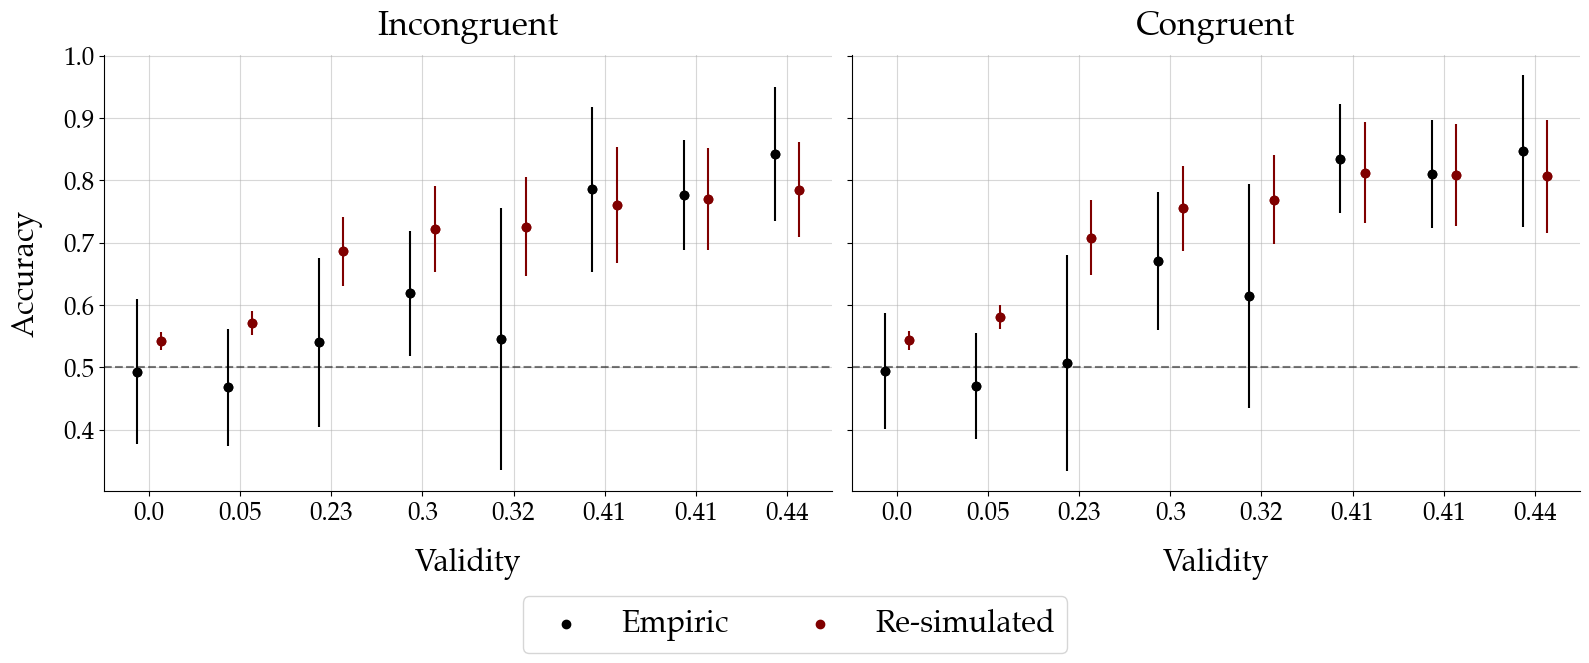

In [68]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, ax in enumerate(axarr.flat):
    for j in range(2):
        ax.scatter(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_acc'],
            color=COLOR[j], label=LABELS[j]
        )
        ax.errorbar(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_acc'],
            yerr= summaries[j].loc[summaries[j].condition == i, 'std_acc'],
            fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
        )
        ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity_context'].unique().round(decimals=2))
    ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Accuracy", labelpad=15, fontsize=FONT_SIZE_2)
        fig.legend(
            fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
            loc="center", ncol=5
        )
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_title(CONDITION_NAMES[i], pad=15, fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.5)
fig.subplots_adjust(hspace=0.5)

fig.tight_layout()
sns.despine()
fig.savefig("../plots/post_resim_accuracy.pdf", dpi=300, bbox_inches="tight")